# RAMP: Predicting french parliament members' political affiliation based on demographic and legislative behavior data 
*Lambi Michalopoulos, Hugo pointier, Vivek Ashokan, Nathan Maligeay, Romain Poupon*

## Table of Contents
* [Introduction](#introduction)
* [The dataset](#dataset)
* [Data exploration](#exploration)
* [Requirements](#requirements)
* [Base model](#base_model)
* [Submitting on RAMP](#submitting)

## Introduction <a class="anchor" id="introduction"></a>


This dataset compiles information on every currently serving member of the French National Assembly. The data is sourced from the National Assembly's open data. This updated dataset brings together details about the deputies, their parliamentary track records, and their present political affiliations into a unified file. Additionally, it incorporates statistical analyses available on the Datan website. The dataset was created on December 3, 2020, and is updated regularly. It was edited by Datan.

Datan is an online tool or platform founded by Awenig Marié, a researcher in political science. Datan aims to analyze parliamentary news through the prism of voting patterns. It offers public information regarding the positions taken by deputies and political groups on specific votes, as well as more detailed statistics often analyzed in scientific literature, such as group cohesion and ideological proximity. Datan was launched in July 2020.

The aim of the data challenge is to predict the political group affiliation of a deputy using demographic and legislative behavior data.

## The dataset <a class="anchor" id="dataset"></a>

The variables are as follows:

- id: ID present on the National Assembly website legislature
- civ: gender of the deputy
- last name
- first name
- city of birth
- birthdate
- age
- group: current parliamentary group
- groupAbrev: abbreviation of the group
- departmentName: name of the department in which the deputy was elected
- departmentCode: code of the department in which the deputy was elected
- constituency: constituency number
- startDate: date on which the deputy took office during the current legislature
- job
- email
- twitter
- facebook
- website
- numberMandates: the number of parliamentary mandates held by the deputy
- parliamentaryExperience: parliamentary experience (in days, months, or years)
- participationScore: the participation score corresponds to the percentage of votes in which the deputy participated in public session
- specialtyParticipationScore: the "specialty" participation score corresponds to the percentage of votes in which the deputy participated in public session and which are related to a legislative text examined in the parliamentary committee of the deputy, and therefore for which the deputy has an interest or expertise
- loyaltyScore: the loyalty score corresponds to the percentage of votes in which the deputy voted along the same line as their parliamentary group
- majorityScore: the score of proximity with the presidential majority corresponds to the percentage of votes in which the deputy voted along the same line as the presidential majority group
- lastUpdateDate: last update date of the dataset


We proceeded with data cleaning:
- We removed the columns "last name," "first name," "city of birth," and "last update date" as they were deemed uninteresting.
- "Birthdate" because it carries the same information as "age".
- "Group" was redundant with "group abbreviation" and was thus removed for simplicity's sake.
- "Number of mandates" was considered redundant with "parliamentary experience" and was therefore omitted.
- "Email," "Twitter," "Facebook," and "Website" columns were deemed uninteresting as they contain unique strings for each deputy.
- "Legislature" was removed as it was consistent across all entries.
- "Department name," "department code," "constituency," "start date," and "job" columns were removed.

## Requirements <a class="anchor" id="requirements"></a>

In [48]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Download Data

In [49]:
# Uncomment the following line to download data:
!python download_data.py

The download file already exists in data/deputes-active.csv


## Data Exploration <a class="anchor" id="exploration"></a>

### Training data 

Here we load the whole .csv file but we will select only the geochemical variables in order to train models for this challenge.

In [53]:
df = pd.read_csv('data/deputes-active.csv')
df

,id,legislature,civ,nom,prenom,villeNaissance,naissance,age,groupe,groupeAbrev,...,twitter,facebook,website,nombreMandats,experienceDepute,scoreParticipation,scoreParticipationSpecialite,scoreLoyaute,scoreMajorite,dateMaj
0,PA1008,16,M.,David,Alain,Libourne,1949-06-02,74,Socialistes et apparentés,SOC-A,...,@AlainDavid_AN,AlainDavidAssembleeNationale,alain-david.com,2,7 ans,0.24,0.75,0.978,0.363,2024-03-02
1,PA1206,16,M.,Dupont-Aignan,Nicolas,Paris,1961-03-07,62,Non inscrit,NI,...,@dupontaignan,nicolasdupontaignan,NaN,5,22 ans,0.05,0.00,0.922,0.157,2024-03-02
2,PA1327,16,M.,Forissier,Nicolas,Paris,1961-02-17,63,Les Républicains,LR,...,@N_Forissier,nicolas.forissier,NaN,3,12 ans,0.10,0.00,0.907,0.858,2024-03-02
3,PA1567,16,M.,Guedj,Jérôme,Pantin,1972-01-23,52,Socialistes et apparentés,SOC-A,...,@JeromeGuedj,jerome.guedj,jerome-guedj.fr/,3,3 ans,0.19,0.42,0.992,0.302,2024-03-02
4,PA1592,16,M.,Habib,David,Paris,1961-03-16,62,Non inscrit,NI,...,@DavidDhabib,DavidHabib64,www.david-habib.fr,5,22 ans,0.04,0.01,0.899,0.913,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,PA805166,16,Mme,Bergantz,Anne,Chalons-sur-Saône,1968-09-17,55,Démocrate (MoDem et Indépendants),DEM,...,NaN,NaN,NaN,1,1 an,0.45,0.77,0.985,0.971,2024-03-02
573,PA817203,16,Mme,Miller,Laure,Reims,1983-12-25,40,Renaissance,RE,...,NaN,NaN,NaN,1,1 an,0.29,0.33,0.997,0.997,2024-03-02
574,PA817211,16,M.,Pilato,René,Lagny-sur Marne,1962-08-31,61,La France insoumise - Nouvelle Union Populaire...,LFI-NUPES,...,@PilatoRene,René Pilato,renepilato.fr/,1,1 an,0.33,0.35,0.989,0.249,2024-03-02
575,PA822617,16,Mme,Froger,Martine,Blois,1961-06-11,62,"Libertés, Indépendants, Outre-mer et Territoires",LIOT,...,MartineFrogerAN,NaN,NaN,1,1 an,0.11,0.17,0.909,0.598,2024-03-02


In [64]:
df.columns, df.columns.shape

(Index(['id', 'legislature', 'civ', 'nom', 'prenom', 'villeNaissance',
        'naissance', 'age', 'groupe', 'groupeAbrev', 'departementNom',
        'departementCode', 'circo', 'datePriseFonction', 'job', 'mail',
        'twitter', 'facebook', 'website', 'nombreMandats', 'experienceDepute',
        'scoreParticipation', 'scoreParticipationSpecialite', 'scoreLoyaute',
        'scoreMajorite', 'dateMaj'],
       dtype='object'),
 (26,))

<Axes: >

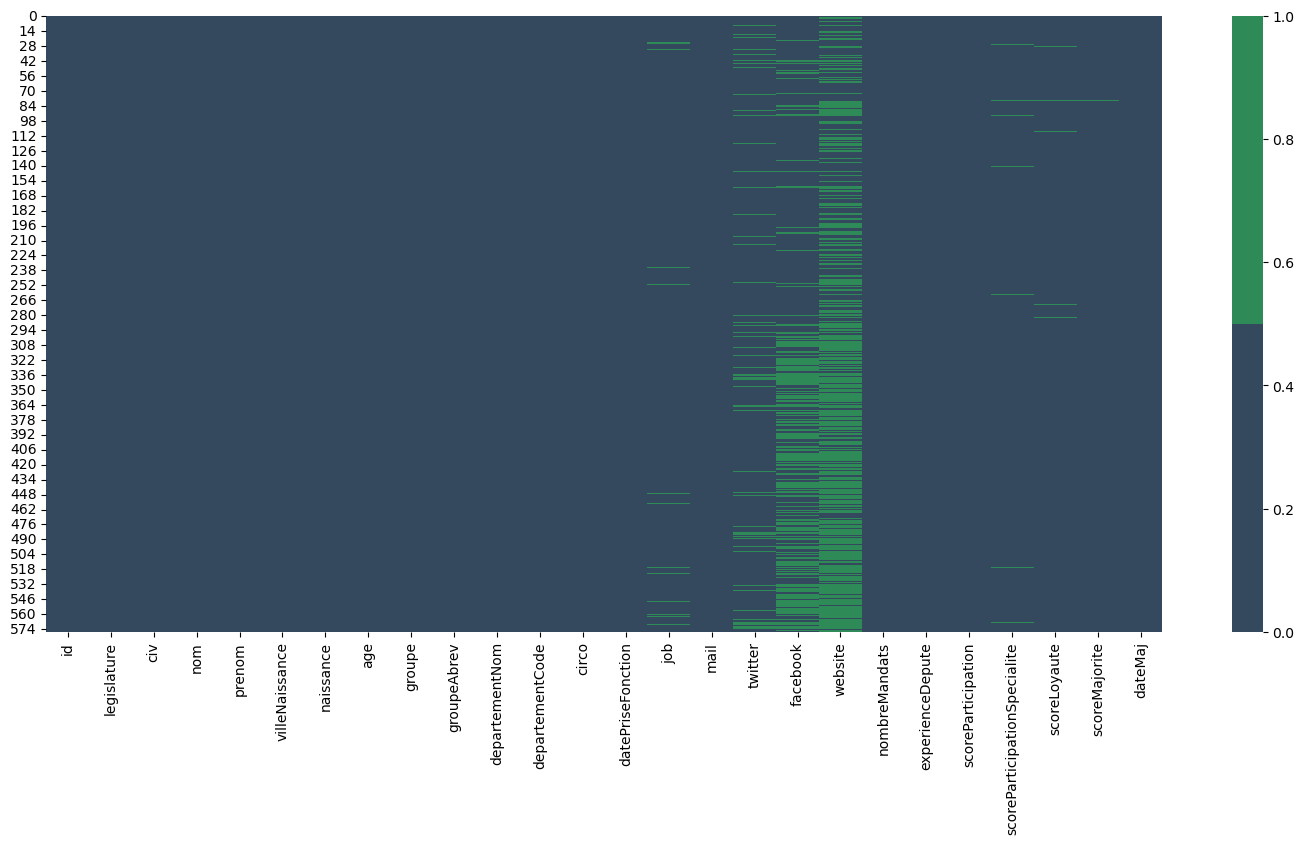

In [54]:
# Missingness
plt.figure(figsize=(18,8))

colours = ['#34495E', 'seagreen'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

The columns with the most missing values are "Twitter," "Facebook," and "Website." These are unimportant columns and will be removed. Other than these columns, the dataset contains very few missing values.

## Labels
The target variable is in the column 'groupeAbrev' since we classify political affiliation.
Here we show the column 'groupe' to show the whole name of political groups.

In [55]:
df.groupe.unique().shape, df.groupe.unique()

((11,),
 array(['Socialistes et apparentés', 'Non inscrit', 'Les Républicains',
        'Renaissance', 'Libertés, Indépendants, Outre-mer et Territoires',
        'Gauche démocrate et républicaine - NUPES',
        'Horizons et apparentés', 'Démocrate (MoDem et Indépendants)',
        'Écologiste - NUPES',
        'La France insoumise - Nouvelle Union Populaire écologique et sociale',
        'Rassemblement National'], dtype=object))

There are 11 groups to classify deputees from.

In [56]:
df.groupe.value_counts(dropna=False)

groupe
Renaissance                                                             169
Rassemblement National                                                   88
La France insoumise - Nouvelle Union Populaire écologique et sociale     75
Les Républicains                                                         62
Démocrate (MoDem et Indépendants)                                        50
Socialistes et apparentés                                                31
Horizons et apparentés                                                   30
Libertés, Indépendants, Outre-mer et Territoires                         22
Gauche démocrate et républicaine - NUPES                                 22
Écologiste - NUPES                                                       22
Non inscrit                                                               6
Name: count, dtype: int64

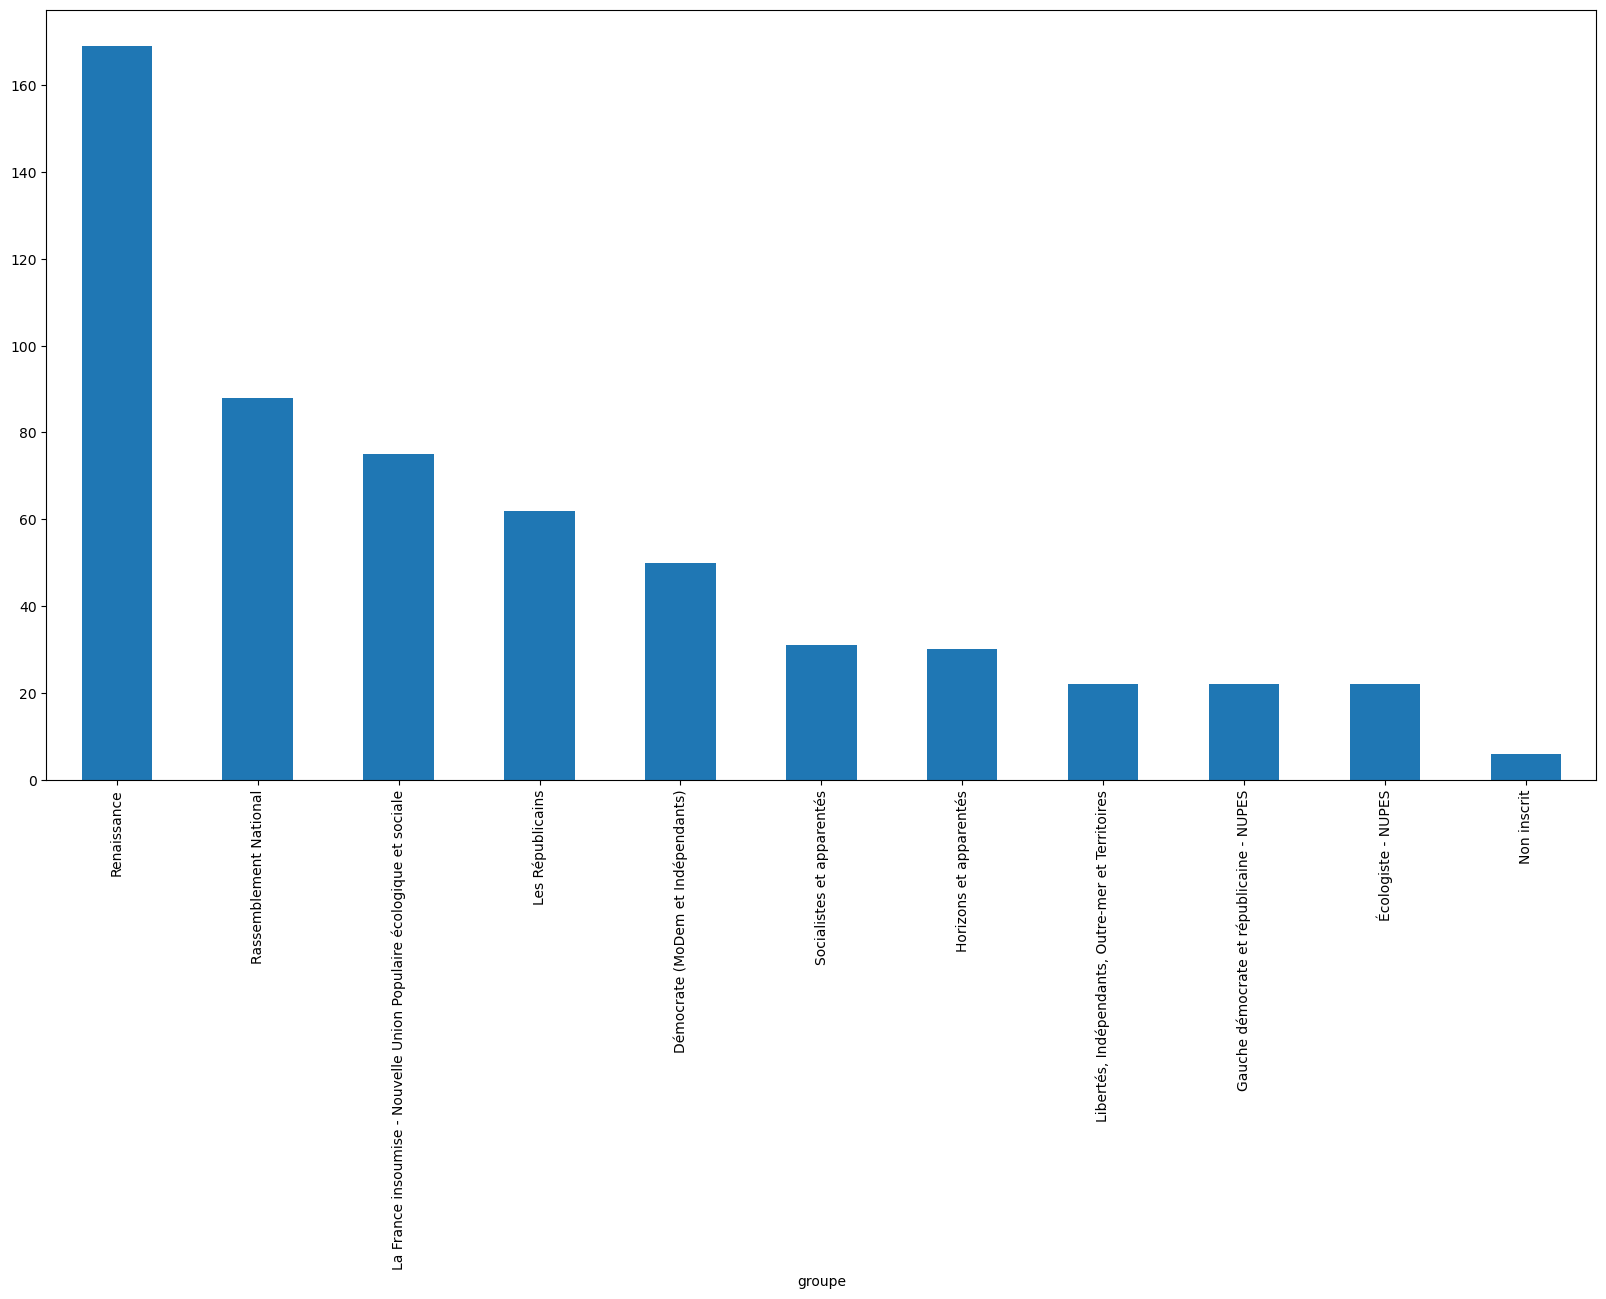

In [57]:
ax_pub = df.groupe.value_counts(normalize=False).plot(kind='bar', figsize=(20, 10))

You can see that we deal with an imbalanced dataset, where some classes have  almost 30 times more observations than others. 

### Sample groups

In [62]:
# Distribution of groups in each class
group_class_counts = df.groupby(['groupe', 'scoreLoyaute']).size().unstack(fill_value=0)
group_class_counts

scoreLoyaute,0.753,0.766,0.781,0.794,0.813,0.818,0.822,0.826,0.830,0.831,...,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999,1.000
groupe,,,,,,,,,,,,,,,,,,,,,
Démocrate (MoDem et Indépendants),0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Gauche démocrate et républicaine - NUPES,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,1,0,0,0,0,1
Horizons et apparentés,0,0,0,0,0,0,0,0,0,1,...,2,2,2,0,2,0,1,0,0,1
La France insoumise - Nouvelle Union Populaire écologique et sociale,0,0,0,0,0,0,0,0,0,0,...,4,3,3,4,14,5,13,7,5,3
Les Républicains,0,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
"Libertés, Indépendants, Outre-mer et Territoires",1,0,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Non inscrit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Rassemblement National,0,0,0,0,0,0,0,0,0,0,...,6,4,3,5,5,4,2,0,0,1
Renaissance,0,0,0,0,0,0,0,0,0,0,...,10,10,16,13,11,16,5,9,2,11


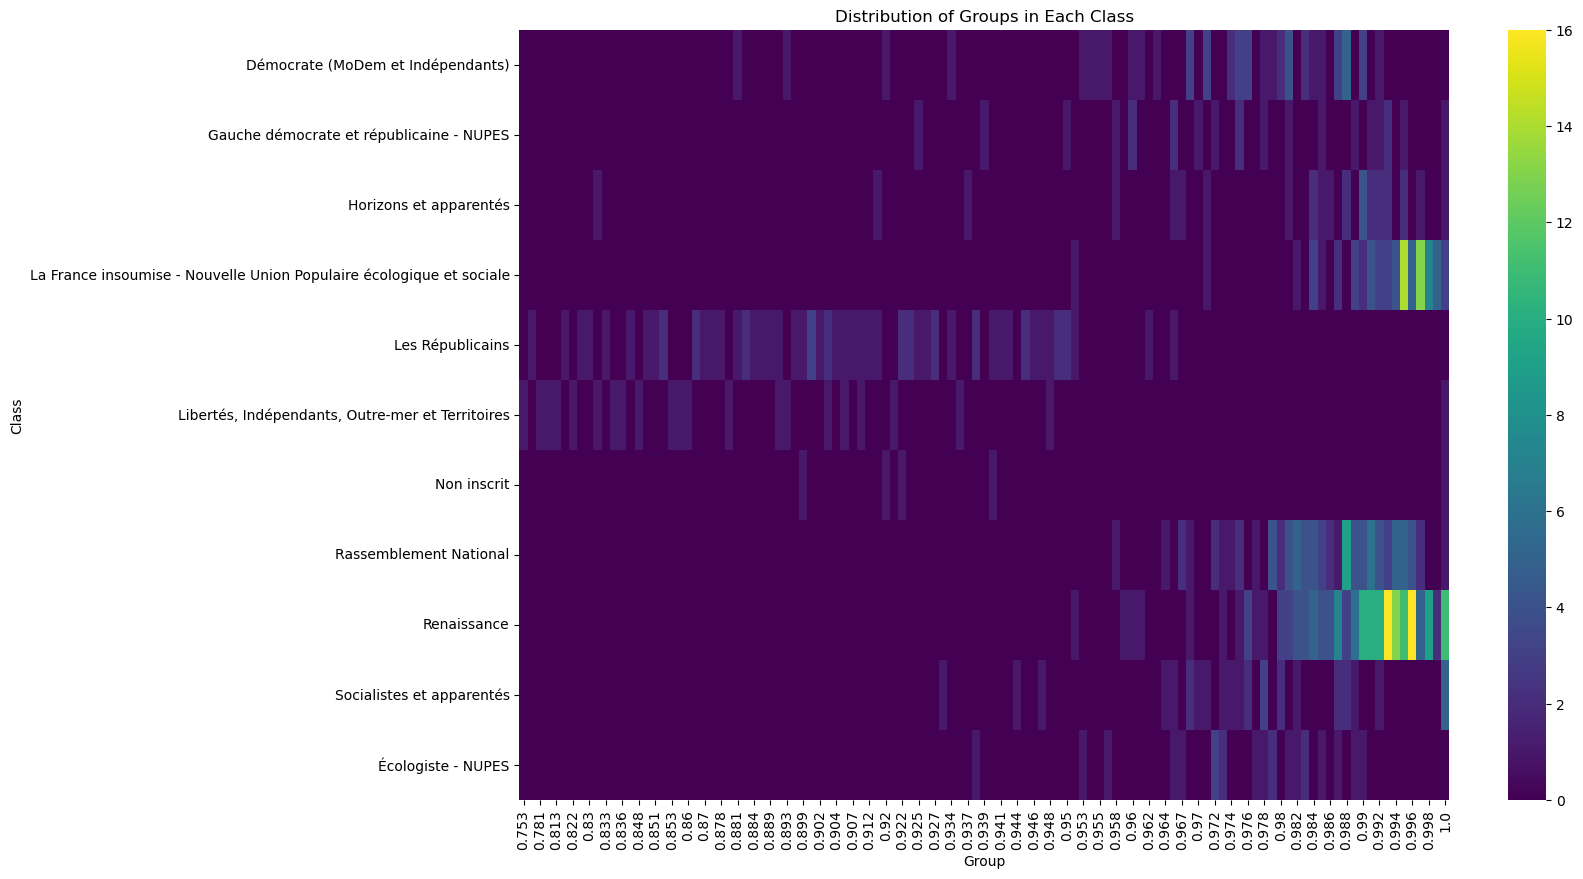

In [63]:
# heatmap of the distribution of groups in each class
plt.figure(figsize=(15, 10))
sns.heatmap(group_class_counts, cmap="viridis")
plt.title('Distribution of Groups in Each Class')
plt.xlabel('Group')
plt.ylabel('Class')
plt.show()

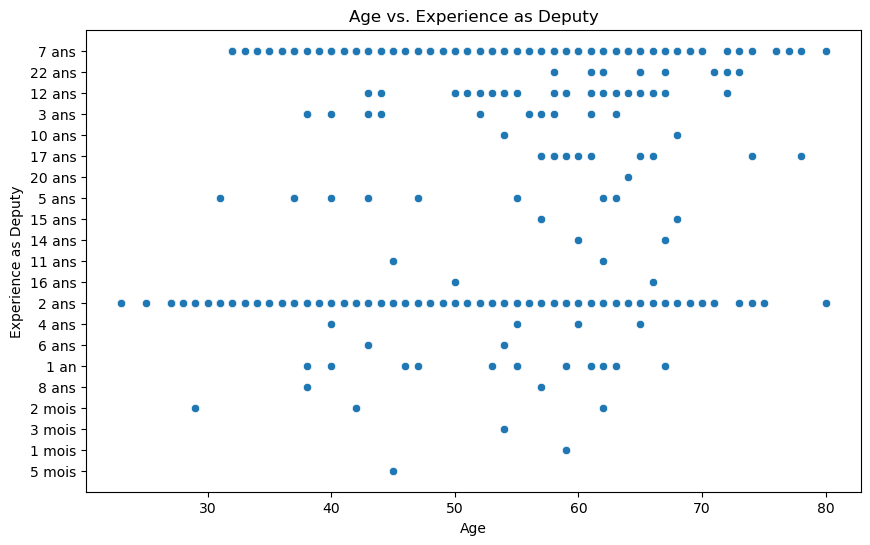

In [69]:
# Scatter plot age vs experience
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='experienceDepute')
plt.title('Age vs. Experience as Deputy')
plt.xlabel('Age')
plt.ylabel('Experience as Deputy')
plt.show()

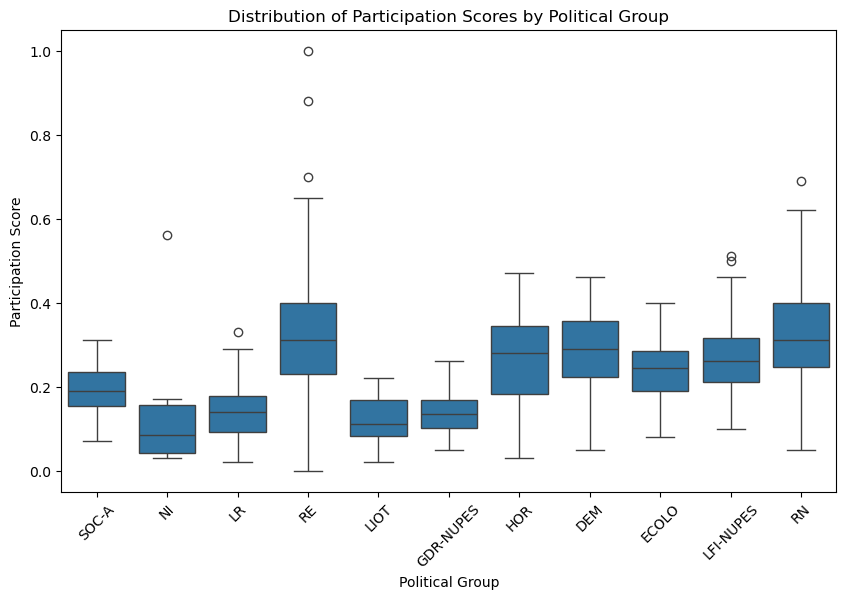

In [66]:
# Box plot score de participation
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='groupeAbrev', y='scoreParticipation')
plt.title('Distribution of Participation Scores by Political Group')
plt.xlabel('Political Group')
plt.ylabel('Participation Score')
plt.xticks(rotation=45)
plt.show()

## Base model <a class="anchor" id="base_model"></a>

### Cleaning data

In [1]:
!python prepare_data.py

Train dataset created
Test dataset created


In [5]:
train = pd.read_csv('data/train.csv')
train

,id,legislature,civ,nom,prenom,villeNaissance,naissance,age,groupe,groupeAbrev,...,twitter,facebook,website,nombreMandats,experienceDepute,scoreParticipation,scoreParticipationSpecialite,scoreLoyaute,scoreMajorite,dateMaj
0,PA795966,16,1,Rambaud,Stéphane,Alger,1960-04-05,1.0,Rassemblement National,RN,...,@stephan1Rambaud,NaN,NaN,1,730.0,0.27,0.20,0.972,0.258,2024-03-02
1,PA795844,16,0,Erodi,Karen,Toulouse,1977-02-04,1.0,La France insoumise - Nouvelle Union Populaire...,LFI-NUPES,...,@KarenErodi,karenerodi2022,NaN,1,730.0,0.27,0.41,0.999,0.253,2024-03-02
2,PA736201,16,0,Taillé-Polian,Sophie,Ermont,1974-10-04,1.0,Écologiste - NUPES,ECOLO,...,@STaillePolian,NaN,NaN,1,730.0,0.14,0.28,0.977,0.253,2024-03-02
3,PA267324,16,1,Gaultier,Jean-Jacques,Épinal,1963-07-13,1.0,Les Républicains,LR,...,@JJ_Gaultier,Jean-Jacques-Gaultier-1088303261286818,NaN,4,6205.0,0.09,0.02,0.938,0.758,2024-03-02
4,PA794762,16,0,Dogor-Such,Sandrine,Tours,1970-11-08,1.0,Rassemblement National,RN,...,@Sandrine_Dogor,NaN,NaN,1,730.0,0.40,0.65,0.982,0.315,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,PA342415,16,0,Battistel,Marie-Noëlle,Grenoble,1956-08-20,1.0,Socialistes et apparentés,SOC-A,...,@BattistelMarie,marienoelle.battistel,www.marienoelle-battistel.fr,4,5110.0,0.24,0.37,0.989,0.379,2024-03-02
452,PA718910,16,0,Colomb-Pitollat,Claire,Marseille,1979-09-17,1.0,Renaissance,RE,...,@clairepitollat,clairepitollat,clairepitollat2022.com,2,2555.0,0.15,0.08,0.996,0.996,2024-03-02
453,PA643089,16,1,Thiériot,Jean-Louis,Paris 14ème,1969-06-26,1.0,Les Républicains,LR,...,@JL_Thieriot,JLTHIERIOT,NaN,2,2190.0,0.09,0.83,0.945,0.829,2024-03-02
454,PA794386,16,0,Métayer,Lysiane,Abidjan,1963-08-07,1.0,Renaissance,RE,...,@Lysiane_Metayer,NaN,NaN,1,730.0,0.43,0.61,0.993,0.993,2024-03-02


<Axes: >

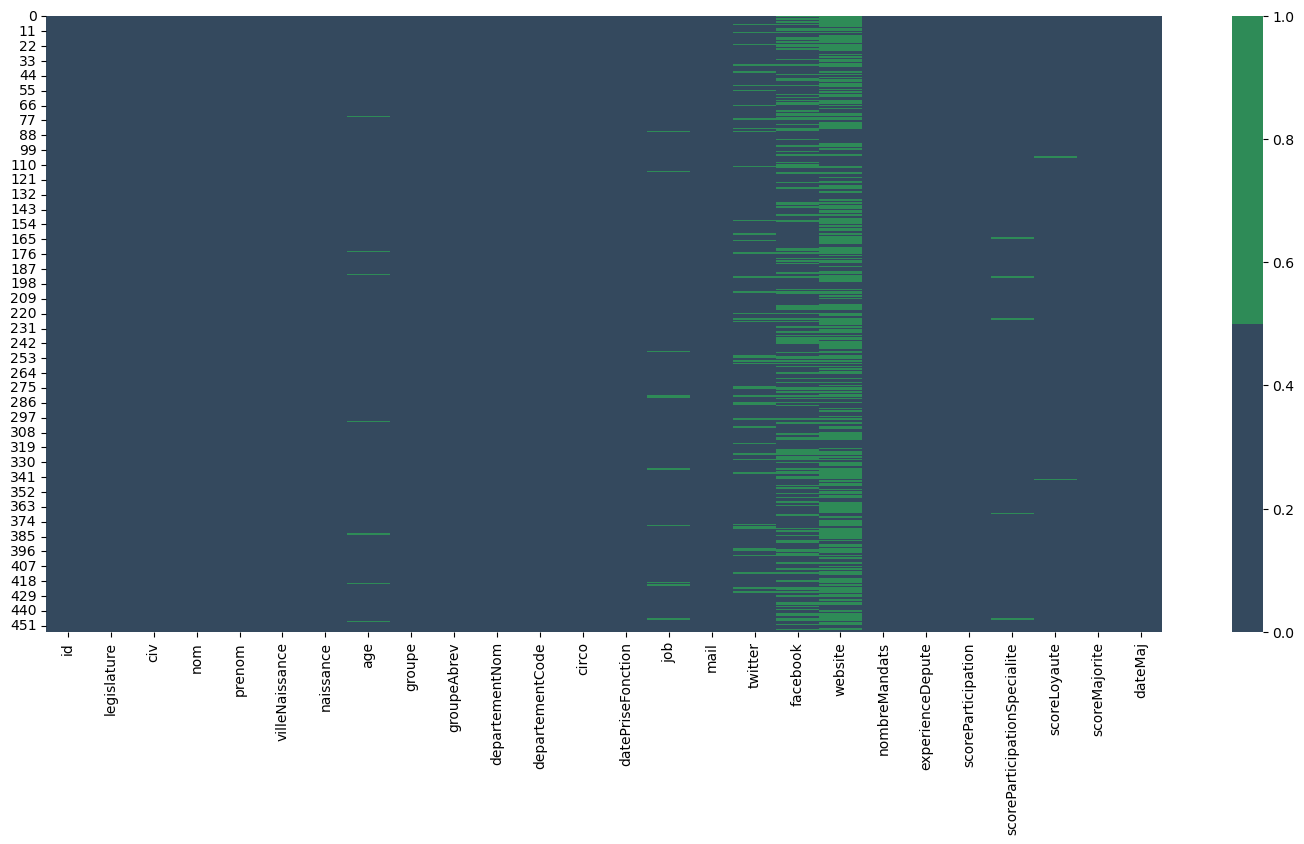

In [67]:
plt.figure(figsize=(18,8))

colours = ['#34495E', 'seagreen'] 
sns.heatmap(train.isnull(), cmap=sns.color_palette(colours))

In [4]:
test = pd.read_csv('data/test.csv')
test

,id,legislature,civ,nom,prenom,villeNaissance,naissance,age,groupe,groupeAbrev,...,twitter,facebook,website,nombreMandats,experienceDepute,scoreParticipation,scoreParticipationSpecialite,scoreLoyaute,scoreMajorite,dateMaj
0,PA331582,16,1,Vigier,Philippe,Valence,1958-02-03,1.0,Démocrate (MoDem et Indépendants),DEM,...,@VigierPhilippe,deputephilippevigier,NaN,4,5840.0,0.24,0.43,NaN,0.965,2024-03-02
1,PA719866,16,0,Abadie,Caroline,Saint Martin D'Heres,1976-09-07,1.0,Renaissance,RE,...,@AbadieCaroline,caroline.abadie.16,www.abadiecaroline.fr,2,2555.0,0.36,0.68,0.993,0.993,2024-03-02
2,PA610654,16,1,Nilor,Jean-Philippe,FORT DE FRANCE,1965-05-15,1.0,La France insoumise - Nouvelle Union Populaire...,LFI-NUPES,...,NaN,Jean-Philippe-NILOR-297068797117195,jpnilor.com,3,4380.0,0.16,0.27,0.971,0.130,2024-03-02
3,PA719756,16,0,Le Nabour,Christine,Noisy-le-Sec,1964-10-28,1.0,Renaissance,RE,...,@ChrisCloarec,ChristineCloarecLaRem,www.christinecloarec.fr,2,2555.0,0.50,0.76,0.996,0.996,2024-03-02
4,PA720100,16,1,Pradié,Aurélien,Cahors,1986-03-14,0.0,Les Républicains,LR,...,@AurelienPradie,aurelien.pradie,www.aurelienpradie.fr,2,2555.0,0.06,0.07,0.852,0.708,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,PA719266,16,1,Cubertafon,Jean-Pierre,Lanouaille,1948-02-05,1.0,Démocrate (MoDem et Indépendants),DEM,...,NaN,jeanpierre.cubertafon,NaN,2,2555.0,0.18,0.55,0.987,0.980,2024-03-02
110,PA793146,16,1,Dragon,Nicolas,Laon,1977-04-19,1.0,Rassemblement National,RN,...,@NicolasDragon,nicolasdragon,www.nicolasdragon.com,1,730.0,0.52,0.86,0.996,0.338,2024-03-02
111,PA793166,16,1,Dessigny,Jocelyn,Noisy Le Grand,1981-06-29,1.0,Rassemblement National,RN,...,@JocelynDessigny,NaN,NaN,1,730.0,0.69,0.66,0.967,0.346,2024-03-02
112,PA266797,16,1,Gosselin,Philippe,Carentan,1966-10-23,1.0,Les Républicains,LR,...,@phgosselin,phgosselin,www.philippegosselin.fr,4,6205.0,0.17,0.28,0.943,0.723,2024-03-02


<Axes: >

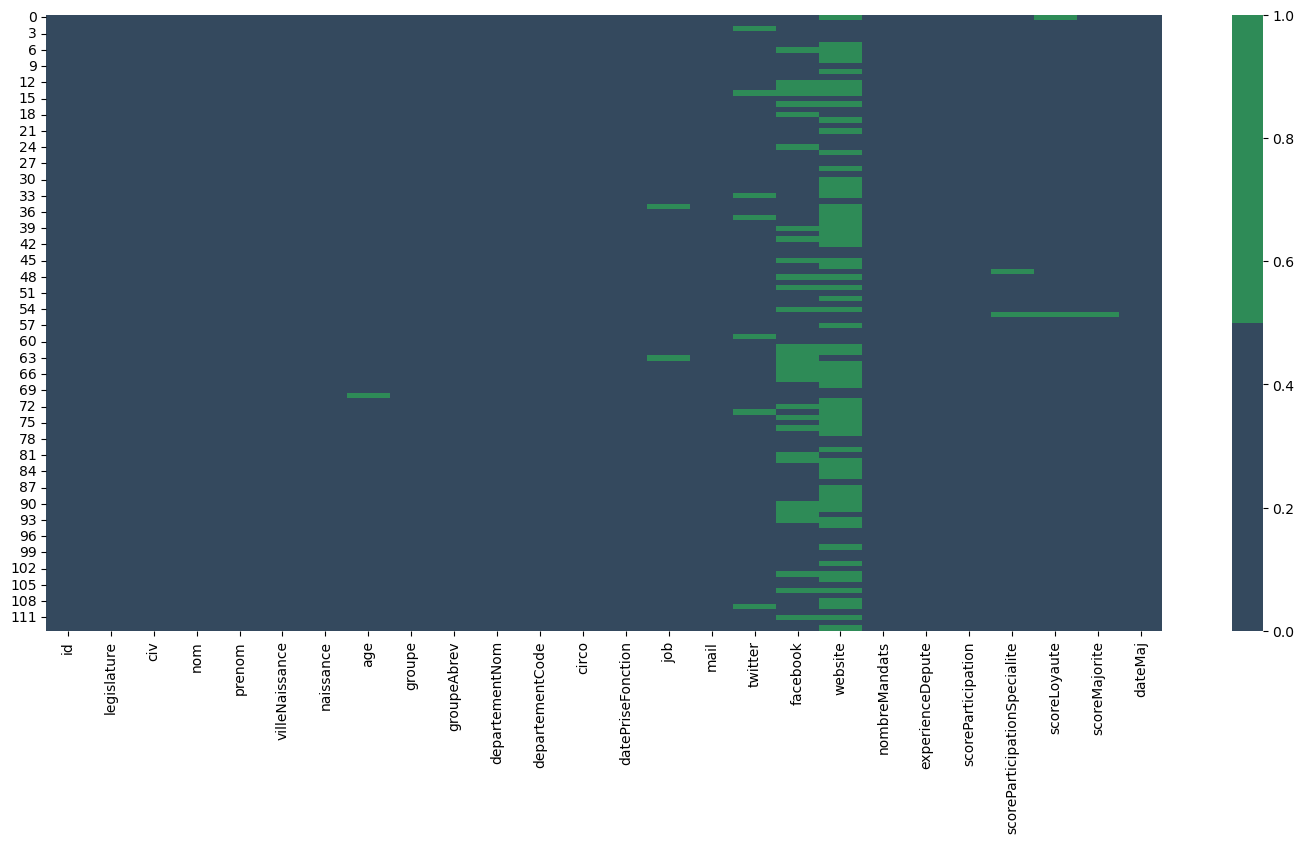

In [68]:
plt.figure(figsize=(18,8))

colours = ['#34495E', 'seagreen'] 
sns.heatmap(test.isnull(), cmap=sns.color_palette(colours))

In [31]:
columns_to_keep = ['civ',
                   'age',
                   'experienceDepute',
                   'scoreParticipation',
                   'scoreParticipationSpecialite',
                   'scoreLoyaute',
                   'scoreMajorite']

In [35]:
X_train = train.loc[:, columns_to_keep]
X_train

,civ,age,experienceDepute,scoreParticipation,scoreParticipationSpecialite,scoreLoyaute,scoreMajorite
0,1,1.0,730.0,0.27,0.20,0.972,0.258
1,0,1.0,730.0,0.27,0.41,0.999,0.253
2,0,1.0,730.0,0.14,0.28,0.977,0.253
3,1,1.0,6205.0,0.09,0.02,0.938,0.758
4,0,1.0,730.0,0.40,0.65,0.982,0.315
...,...,...,...,...,...,...,...
451,0,1.0,5110.0,0.24,0.37,0.989,0.379
452,0,1.0,2555.0,0.15,0.08,0.996,0.996
453,1,1.0,2190.0,0.09,0.83,0.945,0.829
454,0,1.0,730.0,0.43,0.61,0.993,0.993


In [36]:
X_test = test.loc[:, columns_to_keep]
X_test

,civ,age,experienceDepute,scoreParticipation,scoreParticipationSpecialite,scoreLoyaute,scoreMajorite
0,1,1.0,5840.0,0.24,0.43,NaN,0.965
1,0,1.0,2555.0,0.36,0.68,0.993,0.993
2,1,1.0,4380.0,0.16,0.27,0.971,0.130
3,0,1.0,2555.0,0.50,0.76,0.996,0.996
4,1,0.0,2555.0,0.06,0.07,0.852,0.708
...,...,...,...,...,...,...,...
109,1,1.0,2555.0,0.18,0.55,0.987,0.980
110,1,1.0,730.0,0.52,0.86,0.996,0.338
111,1,1.0,730.0,0.69,0.66,0.967,0.346
112,1,1.0,6205.0,0.17,0.28,0.943,0.723


Labels for the train and test sets.
We use a dictionary to store the correspondence between categories and integer labels for this dataset.

In [28]:
# Hard code int_to_cat dict and retrieve cat_to_int with dictionary comprehension to use in all needed files
int_to_cat = {
    0: "SOC-A",
    1: "LR",
    2: "RE",
    3: "LIOT",
    4: "HOR",
    5: "DEM",
    6: "LFI-NUPES",
    7: "GDR-NUPES",
    8: "RN",
    9: "ECOLO",
}

cat_to_int = {v: k for k, v in int_to_cat.items()}


In [29]:
y_train = np.array(train["groupeAbrev"].map(cat_to_int).fillna(-1).astype("int8"))
y_train, y_train.shape

(array([8, 6, 9, 1, 8, 8, 1, 2, 2, 3, 4, 2, 7, 5, 8, 3, 2, 0, 5, 6, 5, 0,
        8, 3, 2, 3, 2, 2, 2, 2, 8, 4, 9, 2, 2, 3, 6, 4, 9, 2, 5, 5, 5, 0,
        2, 6, 2, 2, 2, 0, 0, 7, 4, 6, 1, 5, 6, 1, 1, 8, 2, 0, 7, 5, 8, 2,
        4, 4, 8, 0, 4, 2, 2, 9, 0, 2, 2, 2, 1, 5, 8, 5, 1, 5, 2, 1, 6, 5,
        0, 2, 7, 3, 5, 5, 6, 2, 0, 2, 1, 6, 4, 5, 7, 8, 4, 8, 8, 2, 8, 2,
        2, 8, 5, 2, 9, 1, 6, 9, 2, 2, 2, 3, 2, 6, 8, 8, 2, 8, 2, 2, 2, 2,
        6, 1, 0, 2, 8, 2, 1, 6, 6, 6, 2, 2, 6, 2, 2, 5, 2, 1, 1, 8, 2, 6,
        2, 2, 9, 6, 5, 2, 6, 8, 2, 1, 2, 8, 7, 8, 2, 8, 5, 2, 6, 6, 8, 2,
        2, 0, 1, 8, 4, 8, 2, 4, 0, 2, 2, 2, 2, 2, 8, 6, 0, 7, 4, 8, 9, 6,
        2, 1, 1, 2, 6, 2, 1, 2, 4, 1, 5, 8, 8, 0, 2, 2, 2, 0, 0, 9, 1, 9,
        5, 8, 2, 1, 2, 1, 2, 5, 5, 3, 6, 2, 8, 4, 9, 4, 8, 3, 2, 8, 0, 6,
        3, 8, 2, 4, 2, 2, 9, 8, 2, 3, 1, 1, 5, 2, 6, 7, 2, 8, 2, 8, 5, 1,
        8, 5, 2, 4, 8, 6, 6, 4, 2, 2, 4, 2, 8, 9, 8, 6, 6, 8, 1, 8, 5, 6,
        8, 7, 1, 2, 4, 7, 6, 8, 6, 6, 

In [30]:
y_test = np.array(test["groupeAbrev"].map(cat_to_int).fillna(-1).astype("int8"))
y_test, y_test.shape

(array([5, 2, 6, 2, 1, 2, 1, 1, 1, 2, 0, 0, 2, 8, 2, 3, 2, 6, 2, 6, 0, 2,
        6, 2, 4, 2, 5, 1, 2, 6, 4, 6, 7, 1, 7, 8, 2, 0, 1, 2, 4, 0, 8, 0,
        2, 7, 8, 2, 8, 1, 8, 4, 6, 1, 6, 2, 3, 1, 9, 3, 5, 8, 2, 9, 2, 9,
        5, 2, 8, 0, 2, 8, 6, 5, 6, 3, 5, 5, 2, 8, 6, 2, 2, 6, 1, 9, 3, 2,
        8, 2, 6, 6, 4, 2, 6, 5, 2, 7, 8, 2, 5, 8, 1, 6, 5, 2, 9, 2, 1, 5,
        8, 8, 1, 1], dtype=int8),
 (114,))

Imputation and scaling of the data.

Here we use a SimpleImputer and a StandardScaler.

In [24]:
transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler()),]
)

Classifier: here we take a simple model, logistic regression.

In [25]:
model = LogisticRegression(max_iter=500)
clf = make_pipeline(transformer, model)

Fit the pipeline on train data:

In [37]:
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('logisticregression', LogisticRegression(max_iter=500))])

Evaluation on test data:

In [38]:
y_pred = clf.predict(X_test)

y_pred.shape

Accuracy score

In [41]:
accuracy_score(y_test, y_pred)

0.6666666666666666

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.79      0.73      0.76        15
           2       0.71      0.94      0.81        31
           3       0.33      0.40      0.36         5
           4       0.00      0.00      0.00         5
           5       0.50      0.18      0.27        11
           6       0.88      0.88      0.88        16
           7       0.67      0.50      0.57         4
           8       0.54      0.87      0.67        15
           9       0.00      0.00      0.00         5

    accuracy                           0.67       114
   macro avg       0.49      0.49      0.48       114
weighted avg       0.61      0.67      0.62       114



/home/romain/miniconda3/envs/ramp-tephra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/romain/miniconda3/envs/ramp-tephra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/romain/miniconda3/envs/ramp-tephra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Confusion matrix:

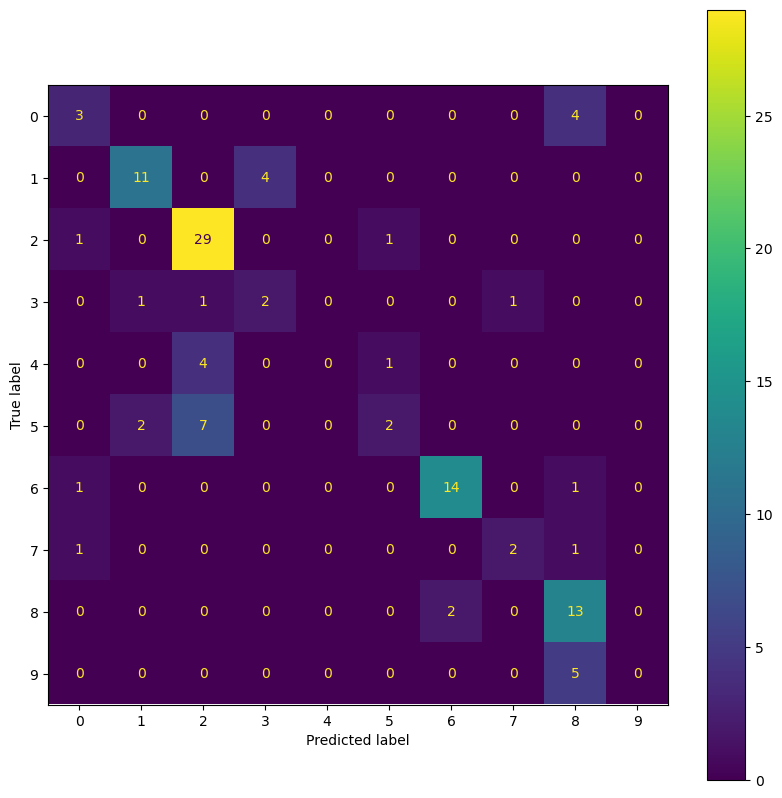

In [43]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)  

Balanced accuracy score will be used as the leaderboard score.

In [44]:
balanced_accuracy_score(y_test, y_pred)

0.49208734813573524

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [french-deputee]. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox] and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions]. Once it is trained, your submission shows up on the [public leaderboard]. 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions]. You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard] is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

This is the score to beat in this challenge.

Here is the script proposed as the starting_kit:

In [45]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


class Classifier(BaseEstimator):
    def __init__(self):
        self.transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        self.model = LogisticRegression(max_iter=500)
        self.pipe = make_pipeline(self.transformer, self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)

You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [ ]:
!ramp-test --submission starting_kit

## Our submission : 

In [46]:
import optuna
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import optuna.visualization as vis


class Classifier(BaseEstimator):
    def __init__(self):
        self.pipe = Pipeline(
            steps=[
                ("model", HistGradientBoostingClassifier(random_state=1234)),
            ]
        )
        

    def objective(self, trial, X, y):

        learning_rate = trial.suggest_float(name="model__learning_rate", low=0.01, high=0.1, log=True)
        max_iter = trial.suggest_int(name="model__max_iter", low=100, high=500)
        max_depth = trial.suggest_int(name="model__max_depth", low=3, high=20, step=1)
        min_samples_leaf = trial.suggest_int(name="model__min_samples_leaf", low=1, high=5, step=1)
        max_bins = trial.suggest_int(name="model__max_bins", low=2, high=255)

        self.pipe.set_params(
            model__learning_rate=learning_rate,
            model__max_iter=max_iter,
            model__max_depth=max_depth,
            model__min_samples_leaf=min_samples_leaf,
            model__max_bins=max_bins,
        )

        self.pipe.fit(X, y)
        cv_score = cross_val_score(self.pipe, X, y, n_jobs=4, cv=5)
        mean_cv_accuracy = cv_score.mean()
        return mean_cv_accuracy

    def fit(self, X, y):
        study = optuna.create_study(direction='maximize')  
        study.optimize(lambda trial: self.objective(trial, X, y), n_trials=10)
        vis.plot_optimization_history(study)
        best_params = study.best_params
        print("Best Hyperparameters:", best_params)
        self.pipe.set_params(**best_params)
        self.pipe.fit(X, y)
  
    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)
    
    def score(self, X, y):
        return self.pipe.score(X, y)

We can test it locally by running the ramp-test command

In [ ]:
!ramp-test --submission my_submission

In this submission, we use optuna to optimize the model's hyperparameters.

## More information

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.